In [4]:
from time import time

import nest_asyncio
import pyarrow.feather as feather
import pandas as pd
import numpy as np
import tensorflow as tf
from models.CNN_2D import create_keras_model
from pathlib import Path

nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)
import gc

gc.collect()


20

In [5]:
EXPERIMENT_NAME = "merge"
this_dir = Path.cwd()

# Load data

In [6]:
data_dir = this_dir / "datasets/csvs"

benign_data = pd.read_csv(data_dir / "benign.csv")
dnscat2_data = pd.read_csv(data_dir / "dnscat2.csv")

dnscat2_data = dnscat2_data.drop("type", axis=1)
# dnscat2_data['label'] = dnscat2_data['type']

In [7]:
benign_data.describe()

,flow_id,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,...,byte_504,byte_505,byte_506,byte_507,byte_508,byte_509,byte_510,byte_511,byte_512,label
count,67660.000000,67660.000000,67660.000000,67660.000000,67660.000000,67660.000000,67660.000000,67660.000000,67660.000000,67660.000000,...,67660.000000,67660.000000,67660.000000,67660.000000,67660.000000,67660.000000,67660.000000,67660.000000,67660.000000,67660.0
mean,1692.000000,99.604286,100.760745,99.120160,100.603429,99.594916,99.821135,99.193763,101.406828,127.885619,...,81.558971,80.845862,80.837895,80.540866,80.327594,79.852616,80.177195,79.518785,79.307080,0.0
std,976.595155,83.957594,84.446257,83.418713,84.375383,84.510162,84.185546,84.237239,81.720739,73.813978,...,85.257821,85.216818,85.111495,85.070814,85.029723,85.013899,85.097603,84.928552,84.932114,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,846.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,9.000000,19.000000,64.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1692.000000,91.000000,93.000000,91.000000,92.000000,92.000000,92.000000,91.000000,91.000000,128.000000,...,54.000000,53.000000,53.000000,53.000000,52.000000,51.000000,52.000000,50.000000,50.000000,0.0
75%,2538.000000,174.000000,175.000000,172.000000,176.000000,175.000000,175.000000,174.000000,173.000000,192.000000,...,156.000000,155.000000,155.000000,155.000000,154.000000,153.000000,154.000000,153.000000,153.000000,0.0
max,3383.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,0.0


In [8]:
dnscat2_data.describe()

,flow_id,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,...,byte_504,byte_505,byte_506,byte_507,byte_508,byte_509,byte_510,byte_511,byte_512,label
count,195760.00000,195760.000000,195760.000000,195760.000000,195760.000000,195760.000000,195760.000000,195760.000000,195760.000000,195760.000000,...,195760.000000,195760.000000,195760.000000,195760.000000,195760.000000,195760.000000,195760.000000,195760.000000,195760.000000,195760.0
mean,4894.50000,127.358950,127.508046,127.338833,127.168722,127.408260,127.686989,127.530609,127.392430,127.804495,...,11.575010,9.249862,8.018058,5.735886,4.384108,2.808362,2.201686,1.393043,1.141301,1.0
std,2825.55942,73.879234,73.927847,74.007058,73.906414,73.934186,74.020141,73.849379,73.795483,73.958254,...,42.916135,38.634433,36.056568,30.743726,26.957805,21.787729,19.249961,15.346175,13.906116,0.0
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2447.75000,63.000000,63.000000,63.000000,63.000000,63.000000,64.000000,64.000000,64.000000,64.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,4894.50000,127.000000,128.000000,127.000000,127.000000,127.000000,128.000000,128.000000,127.000000,128.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,7341.25000,191.000000,192.000000,192.000000,191.000000,191.000000,192.000000,191.000000,191.000000,192.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,9788.00000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,1.0


In [9]:
benign_data.groupby('flow_id').size().count()

3383

In [10]:
dnscat2_data.groupby('flow_id').size().count()

9788

# Split data

In [11]:
# Split benign data into train and test
grouped = benign_data.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_benign = benign_data[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

test_benign = benign_data.drop(train_benign.index)
test_benign.reset_index(drop=True, inplace=True)

In [12]:
# Split dnscat2 data into train and test
grouped = dnscat2_data.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_dnscat2 = dnscat2_data[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

test_dnscat2 = dnscat2_data.drop(train_dnscat2.index)
test_dnscat2.reset_index(drop=True, inplace=True)

In [13]:
# Split benign train data into train and validation
temp = train_benign
grouped = temp.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_benign = temp[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

validate_benign = temp.drop(train_benign.index)
validate_benign.reset_index(drop=True, inplace=True)

In [14]:
# Split dnscat2 train data into train and validation
temp = train_dnscat2
grouped = temp.groupby('flow_id')
arranged = np.arange(grouped.ngroups)
np.random.shuffle(arranged)

train_dnscat2 = temp[grouped.ngroup().isin(arranged[:int(len(arranged) * 0.8)])]

validate_dnscat2 = temp.drop(train_dnscat2.index)
validate_dnscat2.reset_index(drop=True, inplace=True)

# Merge data

In [15]:
# Get the last flow_id of train_dnscat2
max_flow = train_dnscat2['flow_id'].iloc[-1]
# Modify the flow_id of train_benign
train_benign['flow_id'] = train_benign['flow_id'] + max_flow
# Merge the two dataframes
data_train = pd.concat([train_dnscat2, train_benign])

In [16]:
# Get the last flow_id of test_dnscat2
max_flow = test_dnscat2['flow_id'].iloc[-1]
# Modify the flow_id of test_benign
test_benign['flow_id'] = test_benign['flow_id'] + max_flow
# Merge the two dataframes
data_test = pd.concat([test_dnscat2, test_benign])

In [17]:
# Get the last flow_id of validate_dnscat2
max_flow = validate_dnscat2['flow_id'].iloc[-1]
# Modify the flow_id of validate_benign
validate_benign['flow_id'] = validate_benign['flow_id'] + max_flow
# Merge the two dataframes
data_validate = pd.concat([validate_dnscat2, validate_benign])

# Get label

In [18]:
def most_frequent(List):
    return max(set(List), key=List.count)

In [19]:
grouped = data_train.groupby('flow_id')['label'].apply(list).to_dict()

label_train = []
for flow in grouped:
    label_train.append(most_frequent(grouped[flow]))

In [20]:
data_train.groupby('flow_id').size().count()

8428

In [21]:
grouped = data_validate.groupby('flow_id')['label'].apply(list).to_dict()

label_validate = []
for flow in grouped:
    label_validate.append(most_frequent(grouped[flow]))

In [22]:
grouped = data_test.groupby('flow_id')['label'].apply(list).to_dict()

label_test = []
for flow in grouped:
    label_test.append(most_frequent(grouped[flow]))

In [23]:
label_train = np.array(label_train)
label_validate = np.array(label_validate)
label_test = np.array(label_test)

In [24]:
len(label_train), len(label_validate), len(label_test)

(8428, 2108, 2635)

In [25]:
data_train.describe()

,flow_id,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,...,byte_504,byte_505,byte_506,byte_507,byte_508,byte_509,byte_510,byte_511,byte_512,label
count,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,...,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000
mean,6597.041647,120.177213,120.452687,119.746820,120.188064,120.186551,120.365781,120.044061,120.639915,127.920402,...,29.495954,27.552248,26.617175,24.855992,23.737850,22.522508,22.119993,21.317513,21.156306,0.743237
std,3789.792896,77.519513,77.666897,77.499122,77.693793,77.755336,77.738269,77.656192,76.794158,73.935951,...,64.585419,62.752902,61.817897,60.170388,58.937702,57.746679,57.282033,56.282318,56.192083,0.436849
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3345.750000,52.000000,52.000000,51.000000,52.000000,52.000000,52.000000,52.000000,52.000000,64.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6577.500000,120.000000,120.000000,119.000000,120.000000,120.000000,120.000000,120.000000,120.000000,128.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,9876.500000,187.000000,188.000000,187.000000,188.000000,188.000000,188.000000,188.000000,188.000000,192.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,13171.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,1.000000


In [26]:
data_train_without_flow = data_train.drop('flow_id', axis=1)
data_validate_without_flow = data_validate.drop('flow_id', axis=1)
data_test_without_flow = data_test.drop('flow_id', axis=1)

In [27]:
NUM_FEATURE = len(data_test_without_flow.columns) - 1
NUM_CLASSES = len(np.unique(data_test_without_flow['label']))
print(NUM_FEATURE, NUM_CLASSES)

512 2


In [28]:
data_train_without_flow.describe()

,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,...,byte_504,byte_505,byte_506,byte_507,byte_508,byte_509,byte_510,byte_511,byte_512,label
count,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,...,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000,168560.000000
mean,120.177213,120.452687,119.746820,120.188064,120.186551,120.365781,120.044061,120.639915,127.920402,127.424252,...,29.495954,27.552248,26.617175,24.855992,23.737850,22.522508,22.119993,21.317513,21.156306,0.743237
std,77.519513,77.666897,77.499122,77.693793,77.755336,77.738269,77.656192,76.794158,73.935951,73.893555,...,64.585419,62.752902,61.817897,60.170388,58.937702,57.746679,57.282033,56.282318,56.192083,0.436849
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.000000,52.000000,51.000000,52.000000,52.000000,52.000000,52.000000,52.000000,64.000000,63.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,120.000000,120.000000,119.000000,120.000000,120.000000,120.000000,120.000000,120.000000,128.000000,127.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,187.000000,188.000000,187.000000,188.000000,188.000000,188.000000,188.000000,188.000000,192.000000,191.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,1.000000


In [29]:
168560 / 20

8428.0

In [30]:
x_train = (data_train_without_flow.drop('label', axis=1).to_numpy() / 255).reshape(-1, 20, NUM_FEATURE)
x_validate = np.expand_dims(
    (data_validate_without_flow.drop('label', axis=1).to_numpy() / 255).reshape(-1, 20, NUM_FEATURE), axis=-1)
x_test = np.expand_dims((data_test_without_flow.drop('label', axis=1).to_numpy() / 255).reshape(-1, 20, NUM_FEATURE),
                        axis=-1)

In [31]:
x_train = np.array(x_train)

In [32]:
x_train.shape

(8428, 20, 512)

# Model training

In [33]:
# Initialize the model
client_lr = 3e-4
NUM_ROUNDS = 300
BATCH_SIZE = 8

model = create_keras_model(NUM_FEATURE, NUM_CLASSES)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 512, 32)       832       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 512, 32)       25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 256, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 256, 32)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 256, 64)       18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 256, 64)       36928     
                                                        

2024-04-17 13:35:01.462330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-17 13:35:01.649672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-17 13:35:01.649837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-17 13:35:01.650486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=client_lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
start = time()

history = model.fit(x_train, label_train, epochs=5, batch_size=BATCH_SIZE, shuffle=True,
                    validation_data=(x_validate, label_validate))
end = time() - start

2024-04-17 13:35:02.237332: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 345210880 exceeds 10% of free system memory.
2024-04-17 13:35:02.475731: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 345210880 exceeds 10% of free system memory.


Epoch 1/5


2024-04-17 13:35:03.319972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-17 13:35:03.581732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2024-04-17 13:35:04.076134: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7b7bd8021470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-17 13:35:04.076164: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-04-17 13:35:04.081690: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-17 13:35:04.188029: I tensorflow/compiler/jit/xla_compilation_cache.cc:4

1054/1054 [==============================] - 13s 10ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.9555 - val_loss: 0.0194 - val_sparse_categorical_accuracy: 0.9910
Epoch 2/5
1054/1054 [==============================] - 10s 10ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0147 - val_sparse_categorical_accuracy: 0.9948
Epoch 3/5
1054/1054 [==============================] - 10s 10ms/step - loss: 0.0152 - sparse_categorical_accuracy: 0.9943 - val_loss: 0.0073 - val_sparse_categorical_accuracy: 0.9981
Epoch 4/5
1054/1054 [==============================] - 10s 10ms/step - loss: 0.0095 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0084 - val_sparse_categorical_accuracy: 0.9967
Epoch 5/5
1054/1054 [==============================] - 10s 10ms/step - loss: 0.0111 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.0078 - val_sparse_categorical_accuracy: 0.9981


In [35]:
print(f'Training time: {end} seconds')

Training time: 55.62347078323364 seconds


# Evaluate the model

In [36]:
best_model_accuracy = history.history['sparse_categorical_accuracy'][np.argmin(history.history['loss'])]

In [37]:
_, test_acc = model.evaluate(x_test, label_test, verbose=2, batch_size=BATCH_SIZE, use_multiprocessing=True)

330/330 - 1s - loss: 0.0103 - sparse_categorical_accuracy: 0.9966 - 894ms/epoch - 3ms/step


In [38]:
train_val = str(round(best_model_accuracy*100)) + "_" + str(round(test_acc*100))
train_val

'100_100'

In [39]:
import os

model_dir = this_dir / 'saved_models' / EXPERIMENT_NAME
output_dir = this_dir / 'results' / EXPERIMENT_NAME

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [40]:
model.save(model_dir / 'model.h5')

In [41]:
with open(output_dir / 'parameters.txt', 'w') as f:
    print('client_lr: {}\nEpochs: {}\nBATCH_SIZE: {}'.format(
        client_lr, NUM_ROUNDS, BATCH_SIZE), file=f)
    f.close()

In [42]:
def sec_to_hours(seconds):
    a = seconds//3600
    b = (seconds % 3600)//60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d

total_time = "Time: {}".format(sec_to_hours(end))

text_file = open(output_dir / "time.txt", "w")
n = text_file.write(total_time)
text_file.close()

In [43]:
start = time()
predictions = model.predict(
    x_test, verbose=2, use_multiprocessing=True, batch_size=BATCH_SIZE)
end = time() - start
text_file = open(output_dir / "time.txt", "a")
text_file.write(f'\nPredict time: {sec_to_hours(end)}')
text_file.close()

330/330 - 1s - 758ms/epoch - 2ms/step


In [44]:
flow_pred = np.argmax(predictions, axis=-1)

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Class_mapping = {'FileTransfer': 0, 'Music': 1, 'VoIP': 2, 'youtube': 3}
# Class_mapping = {'FileTransfer': 0, 'Music': 1, 'VoIP': 2, 'Youtube': 3, 'alibaba': 4, 'amazon': 5, 'docs': 6, 'drive': 7, 'ebay': 8, 'facebook': 9, 'photo': 10, 'shopee': 11, 'thegioididong': 12, 'tiki': 13, 'tiktok': 14, 'youtube': 15, 'youtubelive': 16}
# Class_list = list(Class_mapping.keys())
Class_list = ['Benign', 'DoH']

with open(output_dir / 'metrics.txt', 'w') as f:
    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(label_test, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(label_test, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(label_test, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(label_test, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(label_test, flow_pred, target_names=Class_list), file=f)
    f.close()


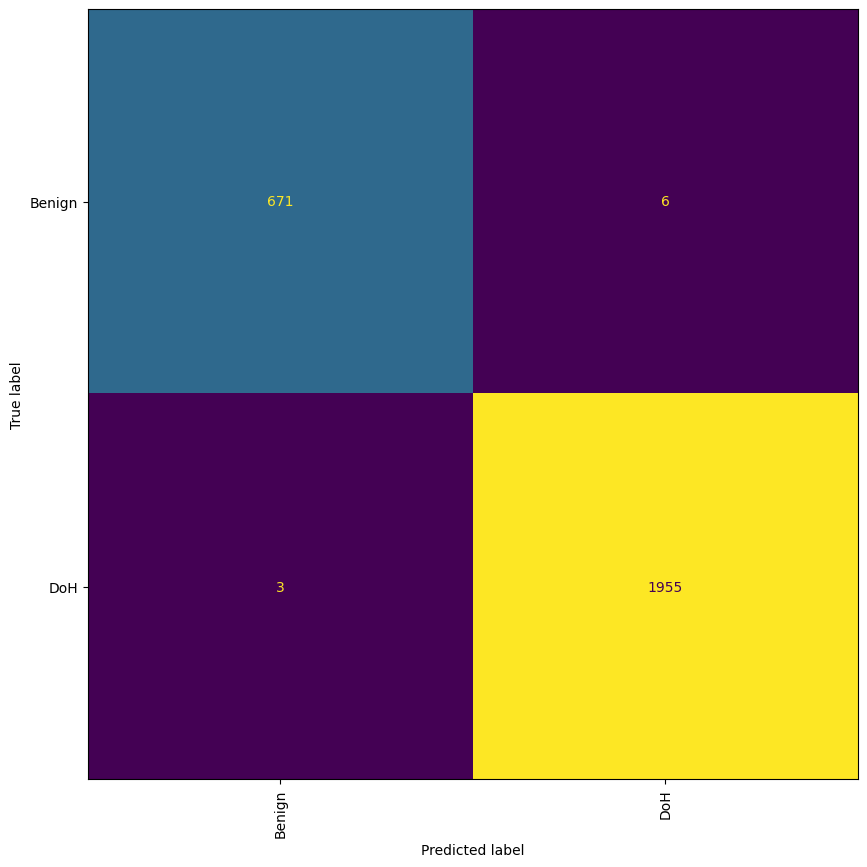

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(label_test, flow_pred,display_labels=Class_list,xticks_rotation='vertical',ax=ax,colorbar=False)
plt.savefig(output_dir / 'ConfusionMatrix.pdf',bbox_inches = "tight")

In [47]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=1)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    plt.savefig(filename,  bbox_inches='tight')

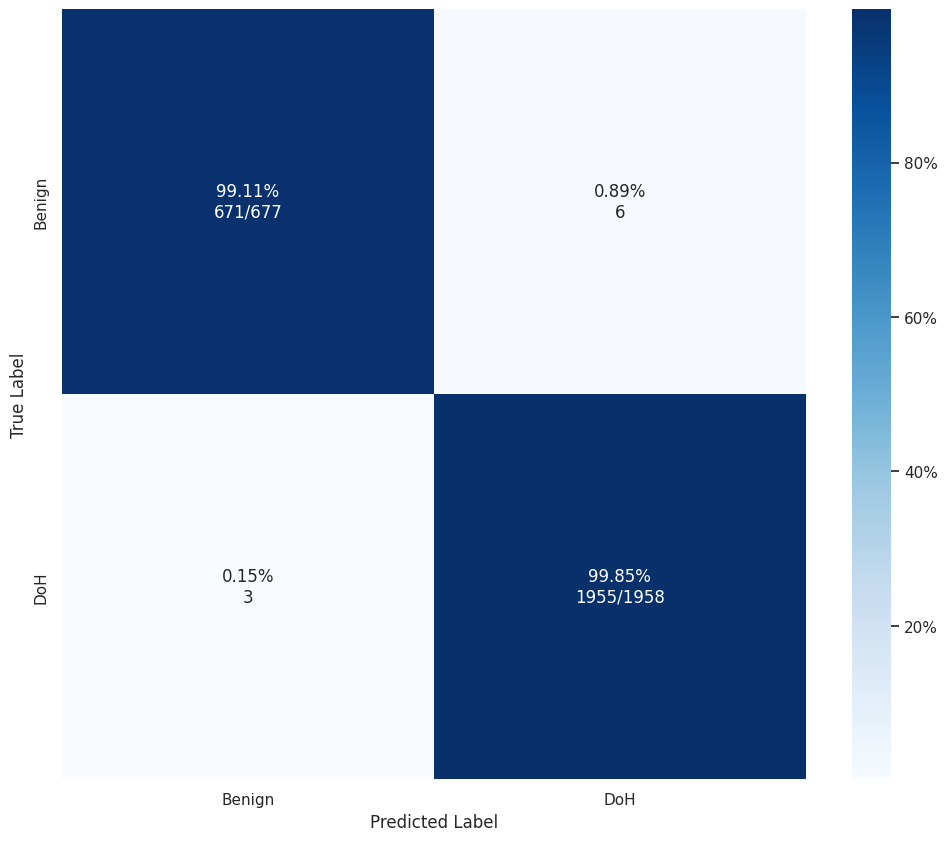

In [48]:
cm_analysis(y_true = label_test,y_pred = flow_pred,filename=output_dir / 'ConfusionMatrix_nom.pdf',labels=[0,1],classes=Class_list,figsize=(12,10))

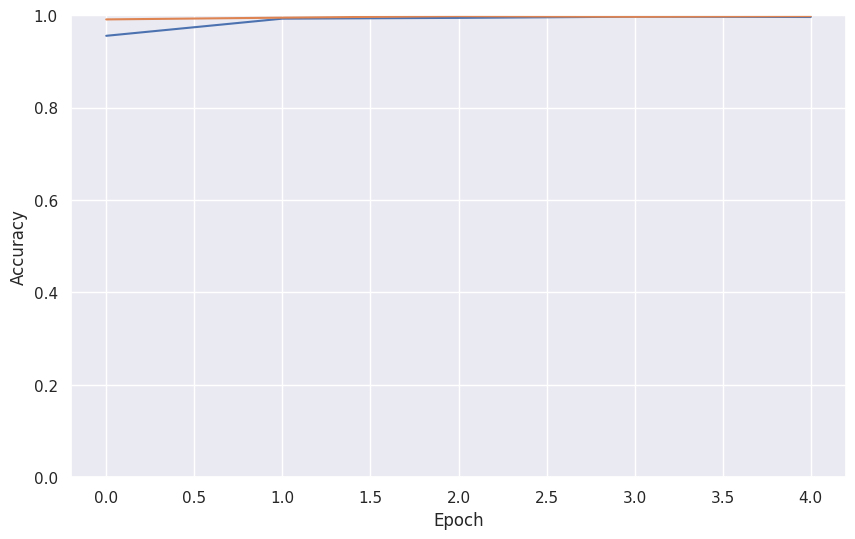

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(
    history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.savefig(output_dir / "normal_model_Accuracy.pdf")

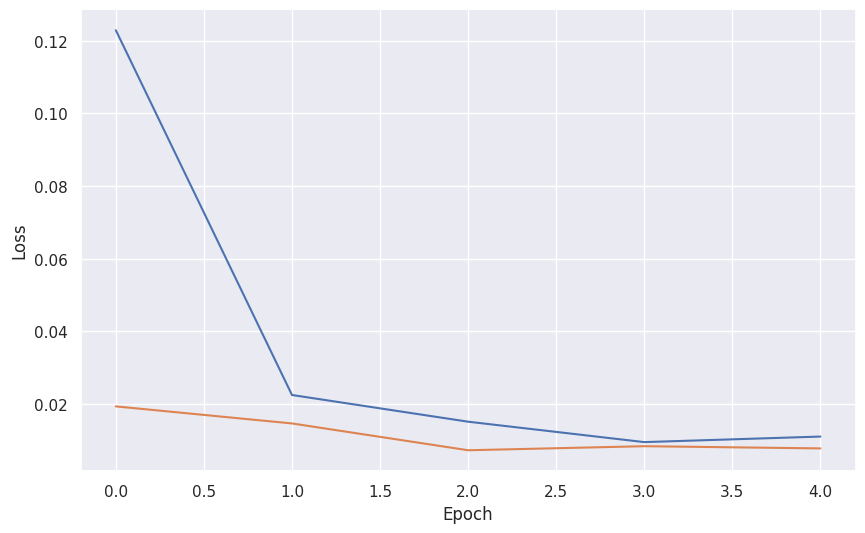

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(output_dir / "normal_model_Loss.pdf")
